# 0. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras

# keras.utils.set_random_seed(12) # 1st weight initialization
keras.utils.set_random_seed(25) # 2nd weight initialization


# 1. Fetch data

## Read

In [2]:
df = pd.read_csv('data_lab3v01.csv', names=['x', 'y', 'target'])
df['target'] -= 1
num_classes = len(df['target'].unique())
df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop = True, inplace=True)
df.tail()


,x,y,target
495,2.1540,3.4419,2
496,3.9004,6.0342,1
497,1.5841,4.8727,3
498,2.0883,2.6763,2
499,4.4741,6.5802,1


In [3]:
df['target'].value_counts()

target
2    150
1    150
3    100
0    100
Name: count, dtype: int64

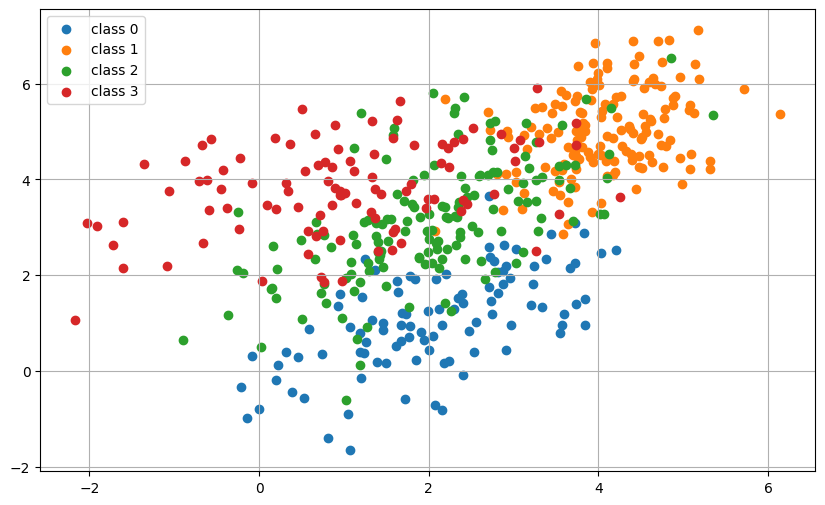

In [4]:
plt.figure(figsize=(10, 6))
for t in range(num_classes):
    plt.scatter(df['x'][df['target'] == t], df['y'][df['target'] == t], label=f'class {t}')
plt.grid()
plt.legend()
plt.show()


## Input transform

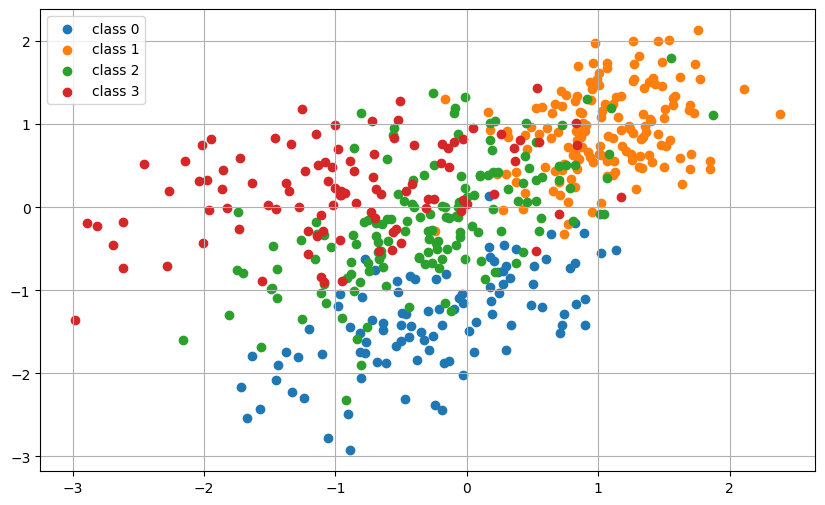

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['x', 'y']] = scaler.fit_transform(df[['x', 'y']])

plt.figure(figsize=(10, 6))
for t in range(num_classes):
    plt.scatter(df['x'][df['target'] == t], df['y'][df['target'] == t], label=f'class {t}')
plt.grid()
plt.legend()
plt.show()


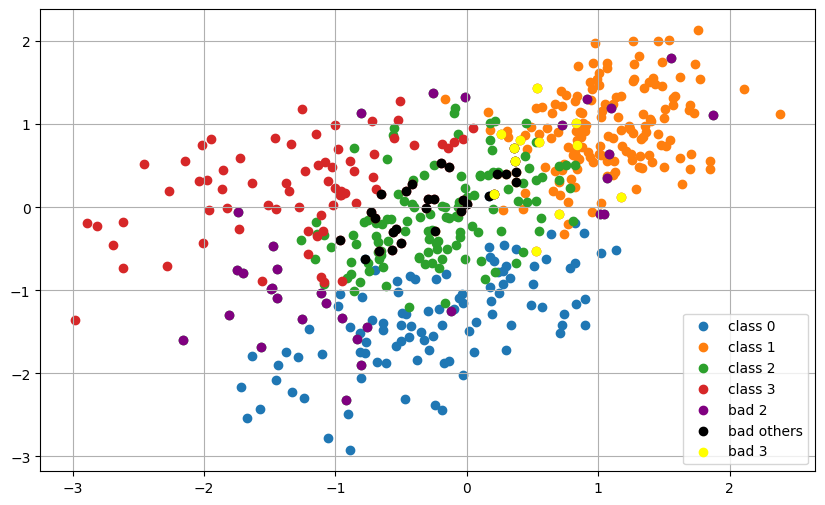

In [6]:
plt.figure(figsize=(10, 6))
for t in range(num_classes):
    plt.scatter(df['x'][df['target'] == t], df['y'][df['target'] == t], label=f'class {t}')

df2 = df[df['target'] == 2].copy()
mean_x, mean_y = df2['x'].mean(), df['y'].mean()
mean_d = ((df2['x'] - mean_x)**2 + (df2['y'] - mean_y)**2).sum() / len(df2)
df2_bad = df2[(df2['x'] - mean_x)**2 + (df2['y'] - mean_y)**2 > 1.5 * mean_d]
plt.scatter(df2_bad['x'], df2_bad['y'], color='purple', label='bad 2')

df_others = df[(df['target'] != 2) & (6 * (df['x'] - df['y'] - mean_x + mean_y)**2 + (df['x'] + df['y'] - mean_x - mean_y)**2 < 2)]
plt.scatter(df_others['x'], df_others['y'], color='black', label='bad others')

df3_bad = df[(df['target'] == 3) & (df['x'] > 0.2)]
plt.scatter(df3_bad['x'], df3_bad['y'], color='yellow', label='bad 3')

plt.grid()
plt.legend()
plt.show()


In [7]:
df_others['target'].value_counts()


target
3    22
1     5
0     2
Name: count, dtype: int64

In [8]:
print(f'points to drop from class 2: {len(df2_bad)}')
print(f'points to drop from other classes: {len(df_others)}')
df = df.drop(df2_bad.index)
df = df.drop(df_others.index)
df = df.drop(df3_bad.index, errors='ignore')
print(df['target'].value_counts())


points to drop from class 2: 32
points to drop from other classes: 29
target
1    145
2    118
0     98
3     69
Name: count, dtype: int64


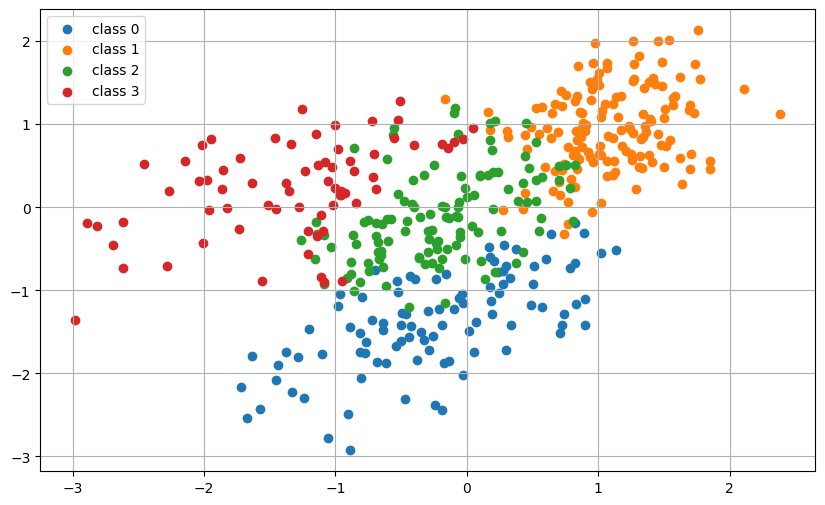

In [9]:
plt.figure(figsize=(10, 6))
for t in range(num_classes):
    plt.scatter(df['x'][df['target'] == t], df['y'][df['target'] == t], label=f'class {t}')
plt.grid()
plt.legend()
plt.show()


## One-hot encoding

In [10]:
old_df = df.copy()
one_hot = pd.get_dummies(df['target'])
df = df.drop('target', axis=1)
df = df.join(one_hot)
df.tail()


,x,y,0,1,2,3
495,-0.189962,0.012893,False,False,True,False
496,0.937692,1.507238,False,True,False,False
497,-0.557948,0.837685,False,False,False,True
498,-0.232385,-0.428442,False,False,True,False
499,1.308131,1.821982,False,True,False,False


In [11]:
def get_counts(y):
    s = ''
    for t in range(num_classes):
        s += f'{t}: {len(y[t][y[t] == True])}\n'
    return s


In [12]:
n = len(df)
n_train = int(n * 0.6)
n_validate = int(n * 0.3)
n_test = n - n_train - n_validate
print(n_train, n_validate, n_test)

targets = [0, 1, 2, 3]

train, validate, test = np.array_split(df, (n_train, n_validate + n_train))
y_train = train[targets]
x_train = train.drop(columns=targets)

y_validate = validate[targets]
x_validate = validate.drop(columns=targets)

y_test = test[targets]
x_test = test.drop(columns=targets)

print('train:', get_counts(y_train), sep='\n')
print('validate:', get_counts(y_validate), sep='\n')
print('test:', get_counts(y_test), sep='\n')


258 129 43
train:
0: 58
1: 84
2: 72
3: 44

validate:
0: 35
1: 46
2: 32
3: 16

test:
0: 5
1: 15
2: 14
3: 9



# 2. Model creation

In [13]:
class LossHistory(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super().__init__()
        self.test_losses = None
        self.test_acc = None
        self.x_test = x_test
        self.y_test = y_test

    def on_train_begin(self, logs=None):
        self.test_losses = list()
        self.test_acc = list()

    def on_epoch_begin(self, epoch, logs=None):
        if logs is None:
            logs = {}
        eval = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        self.test_losses.append(eval[0])
        self.test_acc.append(eval[1])


class InitWeights(keras.callbacks.Callback):
    def __init__(self, layers_idx):
        super().__init__()
        self.weights = None
        self.idx = layers_idx

    def on_train_begin(self, logs=None):
        self.weights = list()
        for k in self.idx:
            self.weights.append(list())
            weights = self.model.layers[k].get_weights()[0][0]
            for i in range(len(weights)):
                self.weights[-1].append(round(weights[i], 3))
        print(self.weights)


In [14]:
model = keras.Sequential(
    [keras.layers.Dense(5, input_dim=len(x_train.columns), use_bias=True, activation='tanh'),
     keras.layers.Dense(5, use_bias=True, activation='tanh'),
     keras.layers.Dense(4, use_bias=True, activation='softmax')])

model.compile(optimizer=tf.optimizers.Adam(0.001), loss=keras.losses.categorical_crossentropy, metrics=[keras.metrics.categorical_accuracy])

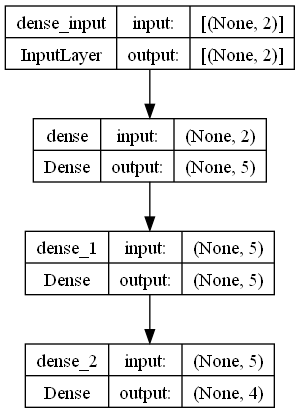

In [15]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [16]:
path = 'save_model.h5'

test_callback = LossHistory(x_test, y_test)
init_weights = InitWeights([0, 1, 2])
callbacks = [keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'), test_callback, init_weights,
             keras.callbacks.ModelCheckpoint(path, monitor='val_loss', save_best_only=True, mode='min')]

history = model.fit(x_train, y_train, batch_size=20, epochs=300,
                    validation_data=(x_validate, y_validate),
                    callbacks=callbacks, verbose=0)
model = keras.models.load_model(path)

train_eval = model.evaluate(x_train, y_train, verbose=0)
validate_eval = model.evaluate(x_validate, y_validate, verbose=0)
test_eval = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_eval[0]}, Train accuracy: {train_eval[1]}, ε: {1 - train_eval[1]}')
print(f'Validate Loss: {validate_eval[0]}, Validate accuracy: {validate_eval[1]},  ε: {1 - validate_eval[1]}')
print(f'Test Loss: {test_eval[0]}, Test accuracy: {test_eval[1]},  ε: {1 - test_eval[1]}')


[[-0.892, 0.048, -0.47, -0.884, 0.477], [-0.41, 0.195, 0.137, -0.145, -0.444], [0.16, -0.468, -0.328, -0.06]]
Train Loss: 0.26162299513816833, Train accuracy: 0.895348846912384, ε: 0.10465115308761597
Validate Loss: 0.34705960750579834, Validate accuracy: 0.8372092843055725,  ε: 0.1627907156944275
Test Loss: 0.36615535616874695, Test accuracy: 0.8837209343910217,  ε: 0.11627906560897827


## Some graphs

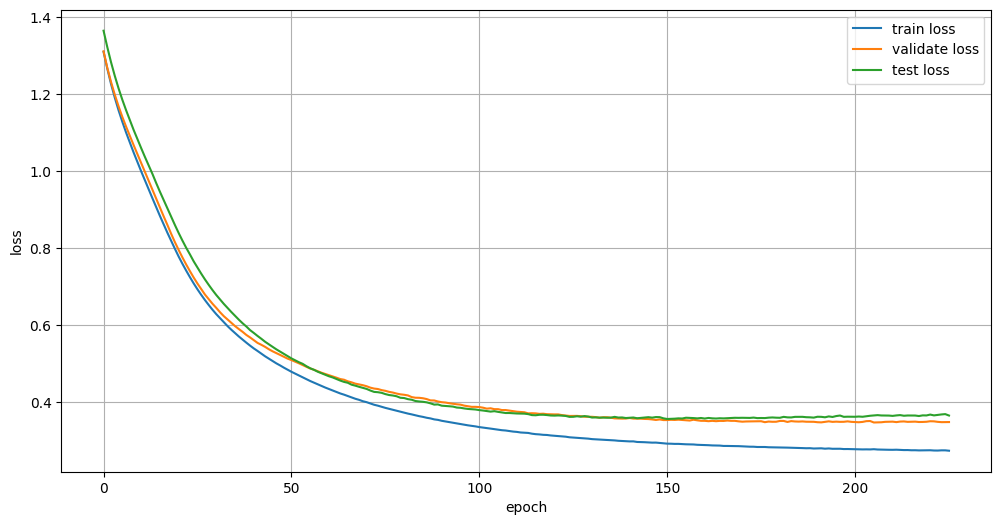

In [17]:
fig = plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validate loss')
plt.plot(test_callback.test_losses, label='test loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()


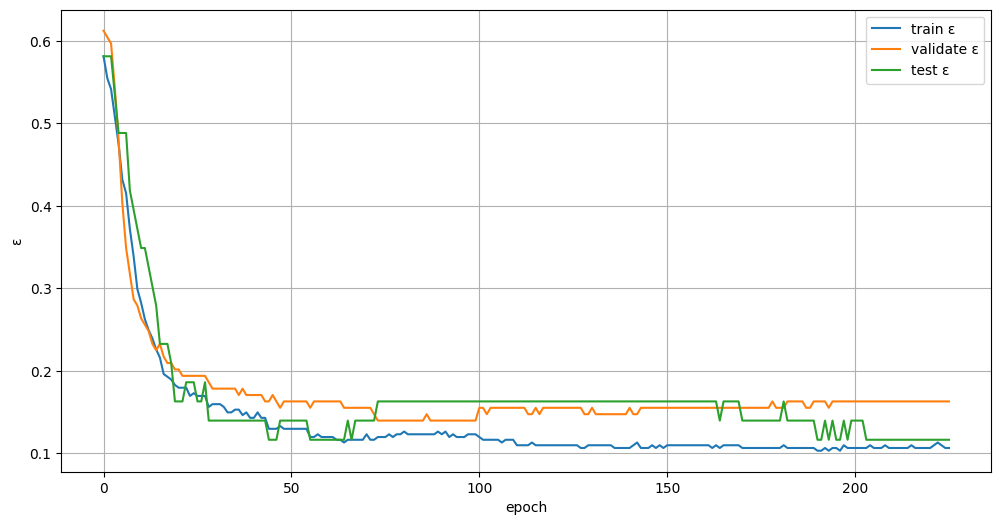

In [18]:
fig = plt.figure(figsize=(12, 6))
plt.plot(1 - np.array(history.history['categorical_accuracy']), label='train ε')
plt.plot(1 - np.array(history.history['val_categorical_accuracy']), label='validate ε')
plt.plot(1 - np.array(test_callback.test_acc), label='test ε')
plt.ylabel('ε')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()


2/2 [==============================] - 0s 0s/step


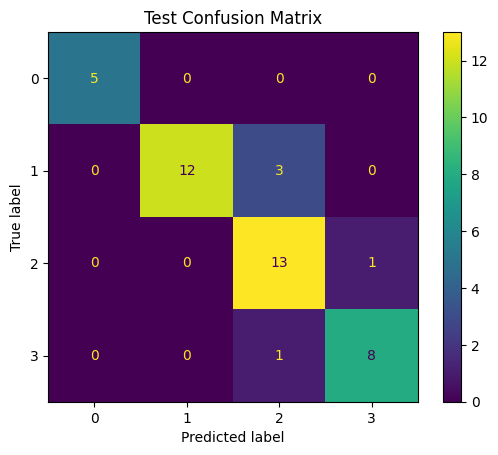

In [19]:
cm = confusion_matrix(y_test.idxmax(axis = 1), np.argmax(model.predict(x_test), axis=1).reshape(-1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Test Confusion Matrix')
plt.show()


9/9 [==============================] - 0s 1000us/step


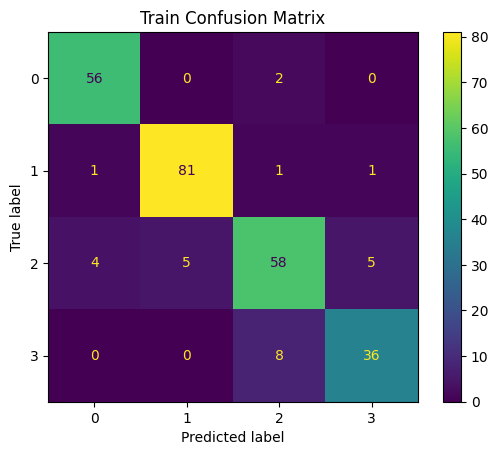

In [20]:
cm = confusion_matrix(y_train.idxmax(axis = 1), np.argmax(model.predict(x_train), axis=1).reshape(-1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Train Confusion Matrix')
plt.show()


In [21]:
from sklearn.inspection import DecisionBoundaryDisplay

feature_1, feature_2 = np.meshgrid(
    np.linspace(df['x'].min(), df['x'].max()),
    np.linspace(df['y'].min(), df['y'].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
feature_df = pd.DataFrame({'x': feature_1.ravel(), 'y': feature_2.ravel()})


79/79 [==============================] - 0s 1ms/step


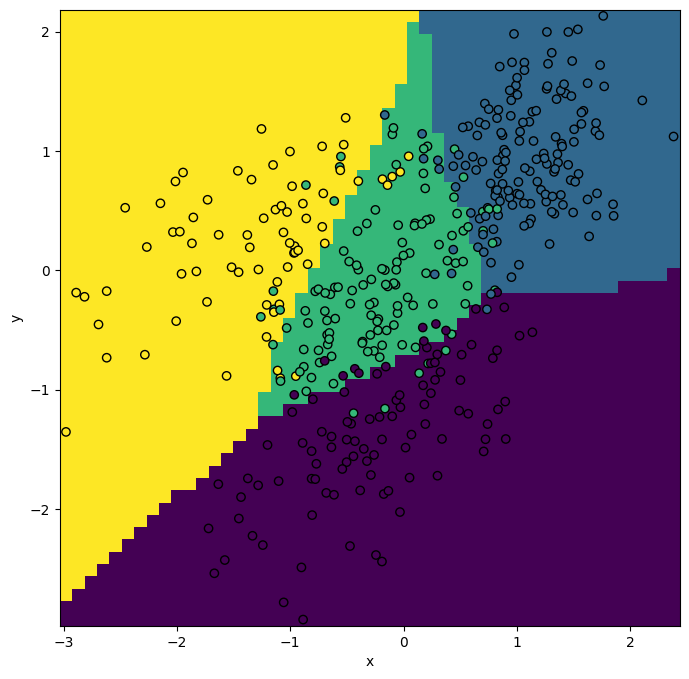

In [21]:
y_pred = np.reshape(np.argmax(model.predict(feature_df), axis=1), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred, xlabel='x', ylabel='y'
)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

display.plot(plot_method='pcolormesh', ax=ax)
display.ax_.scatter(
    old_df['x'], old_df['y'], c=old_df['target'], edgecolor="black",
)

plt.show()
